In [1]:
from dataclasses import dataclass
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
def system(M, C, K, x0, xd0, F=None):
    sys = {
        "M": np.array(M),
        "C": np.array(C),
        "K": np.array(K),
        "x0": np.array(x0),
        "xd0": np.array(xd0)
    }
    N = sys["x0"].shape[0]
    if F is None: sys["F"] = np.zeros((N, 3)) # F = [ A1_i, A2_i, w_i]
    else: sys["F"] = np.array(F)
    # if F is None: sys["F"] = { 'As': 0, 'Ac': 0, 'w'}
    # else: sys["F"] = np.array(F)
    return sys

In [ ]:
def system_mod(sys):
    Ms = np.sqrt(sys["M"])
    sysMod = {
        "Ctilde": np.linalg.inv(Ms) @ sys["C"] @ np.linalg.inv(Ms),
        "Ktilde": np.linalg.inv(Ms) @ sys["K"] @ np.linalg.inv(Ms)
    }

    w, V = np.linalg.eig(sysMod["Ktilde"])        # w = autovalores (possivelmente complexos), V = autovetores em colunas
    idx = np.argsort(np.abs(w))       # ordena pelos autovalores (aqui pelo módulo)
    V_sorted = V[:, idx]           # colunas reordenadas
    w_sorted = w[idx]              # autovalores reordenados
    sysMod["lambdas"] = np.sqrt(w_sorted) # frequências naturais (autovalores naturais)

    P = V_sorted
    sysMod["P"] = P

    S = np.linalg.inv(Ms) @ P
    sysMod["S"] = S
    # print('S.shape\t', S.shape)
    # print('sys[x0].shape\t', sys['x0'].shape)
    # print('S-1.shape\t', np.linalg.inv(S).shape)

    sysMod["r0"] = np.linalg.inv(S) @ sys["x0"]
    # print('sys["x0"]\t', sys["x0"])
    # print('\nsysMod["r0"]\t', sysMod["r0"])
    sysMod["rd0"] = np.linalg.inv(S) @ sys["xd0"]
    # print('\nsys["xd0"]\t', sys["xd0"])
    # print('\nsysMod["rd0"]\t', sysMod["rd0"])

    sysMod["Mmod"] = np.identity(len(sys["M"]))
    sysMod["Cmod"] = P.T @ sysMod["Ctilde"]
    sysMod["Kmod"] = P.T @ sysMod["Ktilde"]

    sysMod["Fmod"] = np.hstack([P.T @ np.linalg.inv(Ms) @ sys["F"][:, :2], sys["F"][:, [2]]])

    return sysMod

In [4]:
def timesampling(N, sys, sysMod):
    Wk = np.array(sys["F"][:, 2])

    fmax = np.maximum(np.max(np.sqrt(sysMod["lambdas"])), np.max(Wk)) / (2*np.pi)

    Ns = 25
    dt = 1 / (Ns * fmax)

    if np.min(Wk) != 0:
        fmin = np.minimum(np.min(np.sqrt(sysMod["lambdas"])), np.min(Wk)) / (2*np.pi)
    else: fmin = np.min(np.sqrt(sysMod["lambdas"]))

    Tmax = N / fmin
    t = np.linspace(0, Tmax, int(Tmax/dt))
    
    return t

In [5]:
def solve_mdof_rk(t_eval, M, C, K, F=None, x0=None, v0=None,
                  method="RK45", rtol=1e-8, atol=1e-10):
    """
    Integra M x¨ + C x˙ + K x = f(t) por Runge–Kutta (solve_ivp).
    - M, C, K: (n×n)
    - f(t): função que retorna vetor (n,)
    - t_eval: array 1D de tempos onde deseja a resposta
    - x0, v0: condições iniciais (n,)
    Retorna: t, x(t), x˙(t), x¨(t)
    """
    n = M.shape[0]
    if F is None:
        def f(t): return np.zeros((n,))
    else:
        def f(t): return (F[:, [0]]*np.sin(F[:, [2]]*t) + F[:, [1]]*np.cos(F[:, [2]]*t)).reshape(-1)
    # print(f)
    # print(f.shape)

    t0, tf = float(t_eval[0]), float(t_eval[-1])
    x0 = np.zeros(n) if x0 is None else np.asarray(x0, float).reshape(-1)
    # print('x0\t', x0)
    # print('x0.shape\t', x0.shape)
    v0 = np.zeros(n) if v0 is None else np.asarray(v0, float).reshape(-1)
    # print('v0\t', v0)
    # print('v0.shape\t', v0.shape)
    z0 = np.hstack([x0, v0])              # z = [x; v]
    # print('z0\t', z0)
    # print('z0.shape\t', z0.shape)

    # RHS do sistema de 1ª ordem
    def rhs(t, z):
        x = z[:n]
        v = z[n:]
        a = np.linalg.solve(M, f(t) - C @ v - K @ x)   # x¨
        return np.hstack([v, a])

    sol = solve_ivp(rhs, (t0, tf), z0, t_eval=t_eval,
                    method=method, rtol=rtol, atol=atol)

    x = sol.y[:n, :].T
    v = sol.y[n:, :].T
    # aceleração em cada passo (opcional)
    a = np.array([np.linalg.solve(M, f(t) - C @ vi - K @ xi)
                  for t, xi, vi in zip(sol.t, x, v)])
    return sol.t, x, v, a

In [26]:
M = [[100]]
C = [[100]]
K = [[910]]
x0 = [[0.001]]
xd0 = [[0.02]]
F = [[0, 10, 3]]
sys = system(M, C, K, x0, xd0, F=F)
sysMod = system_mod(sys)
t = timesampling(17, sys, sysMod)

In [27]:
# print(np.asarray(sysMod["r0"],  float).reshape(-1))
# print(np.asarray(sysMod["rd0"], float).reshape(-1))
t, x, v, a = solve_mdof_rk(
    t_eval=t,
    M=sysMod["Mmod"],
    C=sysMod["Cmod"],
    K=sysMod["Kmod"],
    x0=sysMod["r0"],
    v0=sysMod["rd0"],
    F=sysMod["Fmod"]
)
x = (sysMod["S"] @ x.T).T
v = (sysMod["S"] @ v.T).T
a = (sysMod["S"] @ a.T).T

C:\Users\ymarc\AppData\Local\Temp\ipykernel_4320\4128825981.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


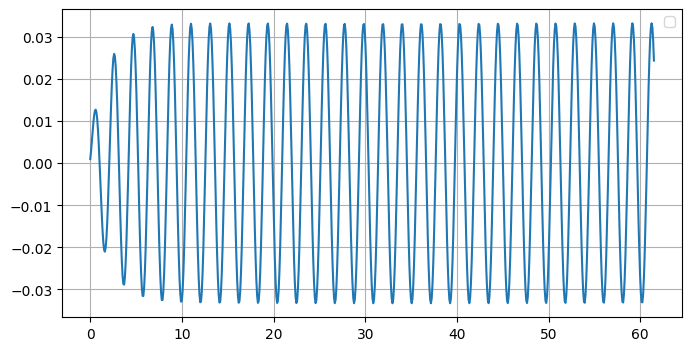

In [28]:
plt.figure(figsize=(8,4))
plt.plot(t, x[:, 0])
# plt.xlabel('Tempo [s]')
# plt.ylabel('Deslocamento')
# plt.title('Resposta no 1º grau de liberdade')
plt.grid(True)
plt.legend()
plt.show()

# plt.figure(figsize=(8,4))
# plt.plot(t, v[:, 0])
# # plt.xlabel('Tempo [s]')
# # plt.ylabel('Deslocamento')
# # plt.title('Resposta no 1º grau de liberdade')
# plt.grid(True)
# plt.legend()
# plt.show()

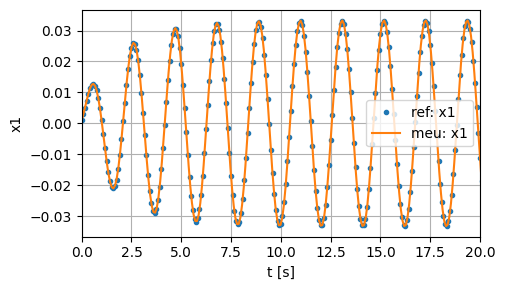

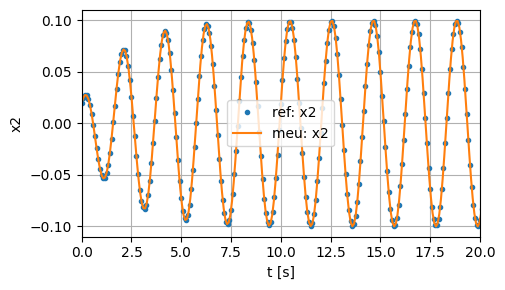

In [32]:
# 1) Ler referência
ref = np.loadtxt('resultado_numerico.txt')   # colunas: t, x1_ref, x2_ref
t_ref, x1_ref, x2_ref = ref.T

# # 3) Interpolar sua solução nos tempos de referência
# x1_my = np.interp(t_ref, t, x_my[:, 0])
# x2_my = np.interp(t_ref, t, x_my[:, 1])

# # 4) Métricas
# def metrics(y_true, y_pred):
#     err = y_pred - y_true
#     rmse = np.sqrt(np.mean(err**2))
#     maxabs = np.max(np.abs(err))
#     rel = rmse / (np.sqrt(np.mean(y_true**2)) + 1e-12)  # RMSE relativo
#     return rmse, maxabs, rel

# print('DOF 1  ->  RMSE, MaxAbs, Rel% =',
#       *metrics(x1_ref, x1_my), sep=' ')
# print('DOF 2  ->  RMSE, MaxAbs, Rel% =',
#       *metrics(x2_ref, x2_my), sep=' ')

# 5) Plots
plt.figure(figsize=(5,3))
plt.plot(t_ref, x1_ref, 'o', ms=3, label='ref: x1')
plt.plot(t,     x, '-',      label='meu: x1')
plt.xlabel('t [s]'); plt.ylabel('x1'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.xlim(0,20)

plt.figure(figsize=(5,3))
plt.plot(t_ref, x2_ref, 'o', ms=3, label='ref: x2')
plt.plot(t,     v[:,0], '-',      label='meu: x2')
plt.xlabel('t [s]'); plt.ylabel('x2'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.xlim(0,20)
plt.show()